In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_indices = list(range(len(data)))[:40000]
validation_indices = list(range(len(data)))[40000:]

# train_sample = torch.utils.data.SubsetRandomSampler(train_indices)
# validation_sample = torch.utils.data.SubsetRandomSampler(validation_indices)


# Subsets of the whole train data using the sampled indices
trainset = torch.utils.data.Subset(data, train_indices)
validationset = torch.utils.data.Subset(data, train_indices)

# Dataloader using the created subsets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('Train set size: ', len(trainloader) * 4)
print('Validation set size: ', len(validationloader) * 4)
print('Test set size: ', len(testloader) * 4)

Train set size:  40000
Validation set size:  40000
Test set size:  10000


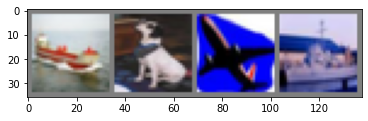

 ship   dog plane  ship


In [4]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

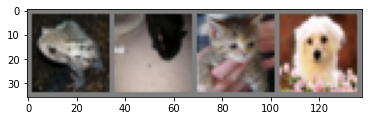

 frog   cat   cat   dog


In [5]:
# Get some random valldation images.
dataiter = iter(validationloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [7]:
class NetMod(nn.Module):
    def __init__(self):
        super(NetMod, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(F.relu(x))
        x = self.dropout(x)
        x = self.fc3(F.relu(x))
        x = F.relu(x)
        return x

net = NetMod()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

NetMod(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [8]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=2, threshold=0.01, verbose=True)

In [9]:
avg_losses = []   # Avg. losses.
validation_losses = []
epochs = 90       # Total epochs.
print_freq = 2000  # Print frequency.
lr_list = set()

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    validation_loss = 0.0
    
    net.train()
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq    
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

    net.eval()
    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            validation_loss += loss.item()
            validation_losses.append(validation_loss)
    net.train()
    
    # If validation error no longer improve, divide the lr by 10
    scheduler.step(validation_loss)
    print('Validation Loss: ', validation_loss)
    lr_list.add(scheduler._last_lr[0])
                            

print('Finished Training.')
print('LR list: ', lr_list)

[epoch: 0, i:  1999] avg mini-batch loss: 2.302796638250351
[epoch: 0, i:  3999] avg mini-batch loss: 2.302796750187874
[epoch: 0, i:  5999] avg mini-batch loss: 2.3025132236480714
[epoch: 0, i:  7999] avg mini-batch loss: 2.3014871473312377
[epoch: 0, i:  9999] avg mini-batch loss: 2.292628651499748
Validation Loss:  22623.708427667618
[epoch: 1, i:  1999] avg mini-batch loss: 2.1740660274624823
[epoch: 1, i:  3999] avg mini-batch loss: 1.9648804277181626
[epoch: 1, i:  5999] avg mini-batch loss: 1.8617260258495807
[epoch: 1, i:  7999] avg mini-batch loss: 1.7937346158325673
[epoch: 1, i:  9999] avg mini-batch loss: 1.6962976417541504
Validation Loss:  16362.033663868904
[epoch: 2, i:  1999] avg mini-batch loss: 1.6205165688842535
[epoch: 2, i:  3999] avg mini-batch loss: 1.5322371452003718
[epoch: 2, i:  5999] avg mini-batch loss: 1.4737923160791397
[epoch: 2, i:  7999] avg mini-batch loss: 1.3928577714189887
[epoch: 2, i:  9999] avg mini-batch loss: 1.3630350987240671
Validation Los

[epoch: 23, i:  9999] avg mini-batch loss: 0.13364676326722275
Validation Loss:  691.0825204598857
[epoch: 24, i:  1999] avg mini-batch loss: 0.07779976706500678
[epoch: 24, i:  3999] avg mini-batch loss: 0.09568631588329561
[epoch: 24, i:  5999] avg mini-batch loss: 0.10446401288861035
[epoch: 24, i:  7999] avg mini-batch loss: 0.12436976227085438
[epoch: 24, i:  9999] avg mini-batch loss: 0.10718231347784697
Validation Loss:  409.19604719454304
[epoch: 25, i:  1999] avg mini-batch loss: 0.08491365216397309
[epoch: 25, i:  3999] avg mini-batch loss: 0.0939001260954529
[epoch: 25, i:  5999] avg mini-batch loss: 0.10104074222167708
[epoch: 25, i:  7999] avg mini-batch loss: 0.10601437253418357
[epoch: 25, i:  9999] avg mini-batch loss: 0.09161319297791096
Epoch 00026: reducing learning rate of group 0 to 1.0000e-04.
Validation Loss:  513.7126458444445
[epoch: 26, i:  1999] avg mini-batch loss: 0.03284039011285819
[epoch: 26, i:  3999] avg mini-batch loss: 0.021493964756189452
[epoch: 26

[epoch: 46, i:  7999] avg mini-batch loss: 0.0016079853590872401
[epoch: 46, i:  9999] avg mini-batch loss: 0.0016287853546168803
Validation Loss:  3.8567063290559886
[epoch: 47, i:  1999] avg mini-batch loss: 0.0016024978768678002
[epoch: 47, i:  3999] avg mini-batch loss: 0.0017774823622175625
[epoch: 47, i:  5999] avg mini-batch loss: 0.0015640775875858655
[epoch: 47, i:  7999] avg mini-batch loss: 0.0019175565370873767
[epoch: 47, i:  9999] avg mini-batch loss: 0.0017312318560958682
Validation Loss:  3.8703740058080243
[epoch: 48, i:  1999] avg mini-batch loss: 0.0018277847287409622
[epoch: 48, i:  3999] avg mini-batch loss: 0.0017661011667126898
[epoch: 48, i:  5999] avg mini-batch loss: 0.0017898255832133189
[epoch: 48, i:  7999] avg mini-batch loss: 0.002061223756117162
[epoch: 48, i:  9999] avg mini-batch loss: 0.0019742906467605454
Validation Loss:  4.096834195765684
[epoch: 49, i:  1999] avg mini-batch loss: 0.0017404099209835744
[epoch: 49, i:  3999] avg mini-batch loss: 0.0

[epoch: 68, i:  9999] avg mini-batch loss: 0.001746375571582484
Validation Loss:  3.735788909070056
[epoch: 69, i:  1999] avg mini-batch loss: 0.0018377271900659365
[epoch: 69, i:  3999] avg mini-batch loss: 0.0017840140953165626
[epoch: 69, i:  5999] avg mini-batch loss: 0.0015763473859355549
[epoch: 69, i:  7999] avg mini-batch loss: 0.0017151372703168093
[epoch: 69, i:  9999] avg mini-batch loss: 0.0016490712419879444
Validation Loss:  3.7357881548350313
[epoch: 70, i:  1999] avg mini-batch loss: 0.00166175527778824
[epoch: 70, i:  3999] avg mini-batch loss: 0.0017786973595346628
[epoch: 70, i:  5999] avg mini-batch loss: 0.001785227091476294
[epoch: 70, i:  7999] avg mini-batch loss: 0.001970153539824991
[epoch: 70, i:  9999] avg mini-batch loss: 0.0016842930330919596
Validation Loss:  3.7357890745415148
[epoch: 71, i:  1999] avg mini-batch loss: 0.001676950014399873
[epoch: 71, i:  3999] avg mini-batch loss: 0.0017270760699733554
[epoch: 71, i:  5999] avg mini-batch loss: 0.001948

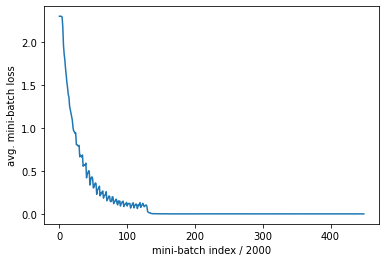

In [10]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

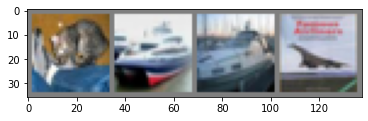

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [11]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [12]:
# Get test accuracy.
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

net.train()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


In [13]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84 %
Accuracy of   car : 90 %
Accuracy of  bird : 71 %
Accuracy of   cat : 62 %
Accuracy of  deer : 80 %
Accuracy of   dog : 72 %
Accuracy of  frog : 85 %
Accuracy of horse : 83 %
Accuracy of  ship : 88 %
Accuracy of truck : 88 %
